<a href="https://colab.research.google.com/github/andrews-j/adleojpa/blob/main/graded_assignment1_jpa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

Work through the assignment 1 notebook, and use this notebook to provide your answers. 

To submit the assignment, you will need to use GitHub.

Using your own GitHub profile:

- Create a private repository called adleoxyz, where the xyz part is replaced with your initials. Note the lower case and the formatting. Please maintain that. If you have only 2 initials or more than 3, please use them.
- Add all three instructors as collaborators to your private repository

Once you have completed the assignment:
- Commit your notebook from colab to your private GitHub repo
- The notebook should be named assignment1_xyz.ipynb, with xyz again replaced by your initials.

# Answers to the theoretical questions

Please provide your answers to questions 1-4 here

**Answer to Q1)**

**Part a - For greyscale image**

First layer learnable parameters:

100x100 vector, times 1000 hidden nodes, plus 1000 biases (one for each node)

(100x100)x1000+1000= 10,001,000

Second layer learnable parameters:

1000 hidden nodes times 10 output categories, plus 10 biases (1 for each layer)
(1,000x10)+10= 10,010

**Part b - For multi-spectral image**

First layer learnable parameters:

100x100x7 tensor, times 1000 hidden nodes, plus 1000 biases (one for each node)
(100x100x7)x1000+10= 70,000,010

Second layer learnable parameters:

1000 hidden nodes times 10 output categories, plus 10 biases (1 for each layer)
(1,000x10)+10= 10,010


**Part c - tensor shapes**

For multi-spectral image

- First layer weight and bias shapes that transform the input to the hidden features:

Weight matrix: Rows equal to the number of neurons in the previous layer (70,000. Columns equal to number of neurons in the next layer (1000)
Shape of the weight matrix here is 70,000 rows and 1000 columns. 

Biases: Single column per layer equal to number of neurons in next layer (10000)

Second layer weight and bias shapes that map from the hidden features to output classes:

- Matrix with 1000 rows and 10 columns

Biases: single column of 10 rows

**<font color='red'>Complete 10/10 points on Q1</font>**

**Answer to Q2**

Because otherwise DNNs would be limited to learning linear relationships between features and outputs. Non-linear activation functions allow DNNs to learn more complex patters.

**<font color='red'>5/5 points on Q2</font>**

**<font color='red'>Linear combination of a linear combination will be in the same linear space. This means that by removing non-linearity for instance a network with 10 FC layers will collapse to a single layer FC.</font>**

**Answer to Q3**

ReLU is much faster to compute than the sigmoid activation function because it uses a max operation, sigmoid is much more complicated. ReLU also avoids the issue of vanishing gradients by assigning any negative value to 0, and anything positive to a gradient of one, as seen in the graphed images here.

**<font color='red'>5/5 points on Q3</font>**

**<font color='red'>The main issue with sigmoid and any other S-shaped function is that they have saturation points near very small or very big inputs. Stacking many sigmoid layers in a deep network leads to a vanishing gradient problem during backpropogation in early layers or exploding gradients at high level layers in the forward pass. RelU family of networks on the other hand doesn't have saturation points are are easy to optimize as the derivative of the function is either 0 or 1.</font>**

**Answer to Q4**

Why is it not common to use shuffling for validation and test datasets? Why is it important to apply shuffling during training?

Shuffling is not common in validation and training sets because it would not make any difference. The order of the inputs only matters when the model is being trained. 

It is important to apply shuffling during training to avoid overfitting. Without shuffling the inputs would enter the model in the same order every time and the model would memorize the data instead of how to generalize the data. 

**<font color='red'>5/5 points on Q4</font>**

**<font color='red'>In mini-batch training with gradient decent instead of the whole dataset we feed the network only a subset where the size is decided by a batch size and the items through a sampling strategy. From the probabilistic view, We want each mini-batch to be a representative of our whole dataset which can be achieved best through a random sampling strategy. From the optimization viewpoint, we want to find the best possible minima in reasonable time on a non-convex surface. The problem is there might be many local minimums in our surface and we might get stuck in one of those minima while a deeper/lower/better solution may lie nearby on the surface. This is likely to occur if the mini-batch input is unchanged, making the loss surface static for that mini-batch over all training epochs. Shuffling changes the mini-batches for each epoch. This changes the loss surface from iteration to interation and between epochs. The effect is that now with the surface changes local minias will change too which gives the optimzation algorithm to bounce out of a possibly bad local minimum. As we don't do optimization on the validation dataset and because of the monitoring rule of the validation curve we prefer to keep the mini-batches and consequently the loss surface fixed to better diagnose our problems in the learning process.</font>**

# Coding Assignment

Follow the instructions below to complete your coding assignment. 

Run the code below unchanged, unless otherwise indicated. 

## Static code 1

Run unchanged

Mount drive and run imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

## Variables to set

- Model save path: Modify 'save_dir' to the path to your already downloaded MNIST dataset (from the main notebook).

In [ ]:
save_dir = "/content/gdrive/MyDrive/sam_mnist/MNIST/raw"

## Static code 2

### Transforms and loads (Steps 1.1-1.5)

Necessary transforms - run unchanged


In [ ]:
mnist_mean = 0.13066048920154572
mnist_std = 0.30810779333114624

train_transforms = transforms.Compose(
    [transforms.RandomRotation(5, fill=(0,)),
     transforms.RandomCrop(28, padding=2),
     transforms.ToTensor(),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
     )

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
     )

Load and split

In [ ]:
train_data = datasets.MNIST(root=save_dir,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=save_dir,
                           train=False,
                           download=True,
                           transform=test_transforms)

train_ratio = 0.9

n_train_examples = int(len(train_data) * train_ratio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,[n_train_examples, 
                                                       n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms
train_bsize= 100

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/sam_mnist/MNIST/raw/MNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/MyDrive/sam_mnist/MNIST/raw/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/sam_mnist/MNIST/raw/MNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/sam_mnist/MNIST/raw/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/sam_mnist/MNIST/raw/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/MyDrive/sam_mnist/MNIST/raw/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/sam_mnist/MNIST/raw/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/sam_mnist/MNIST/raw/MNIST/raw



Make iterable

In [ ]:
# Don't change this cell
train_loader = data.DataLoader(train_data,
                               shuffle=True,
                               batch_size=train_bsize)

valid_loader = data.DataLoader(valid_data,
                               shuffle=False,
                               batch_size=train_bsize)

test_loader = data.DataLoader(test_data,
                              shuffle=False,
                              batch_size=train_bsize)

### Metrics and some other necessary functions

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = Variable(x).to(device)
        y = Variable(y).to(device)

        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    # Disable automatic differentiation as we don't do optimization on eval.
    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = Variable(x).to(device)
            y = Variable(y).to(device)

            y_pred = model(x)
            
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


## Task 1: Adjust the model

Modify your MLP as required

**<font color='red'>Complete 15/15 points on coding task 1</font>**

**<font color='red'>0/5 points on optional 1</font>**

In [ ]:
# Modify this cell
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, drop_rate):
        super(MLP, self).__init__()

        # add your code here
        
        self.mlp_block = nn.Sequential(nn.Linear(in_dim, hidden_dims[0]),
                                       nn.LeakyReLU(),
                                       nn.BatchNorm1d(hidden_dims[0]),
                                       nn.Dropout(drop_rate),
                                       nn.Linear(hidden_dims[0], hidden_dims[1]),
                                       nn.LeakyReLU(),
                                       nn.BatchNorm1d(hidden_dims[1]),
                                       nn.Dropout(drop_rate),
                                       nn.Linear(hidden_dims[1], out_dim))

    def forward(self, x):
      
      # Add your code here.

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        y_pred = self.mlp_block(x)
      
        return y_pred

If you are struggling to get it working, here is a commented out version of the example model that you can run and adapt.  You might want to use some of the other 3 examples that we suggested for structuring the model class

In [ ]:
# class MLP(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(MLP, self).__init__()
        
#         self.input_fc = nn.Linear(input_dim, 250)
#         self.hidden_fc = nn.Linear(250, 100)
#         self.output_fc = nn.Linear(100, output_dim)

#     def forward(self, x):
        
#         # x is a batch of images with the shape: [batch size, height, width]
#         batch_size = x.shape[0]
        
#         # First, we have to convert the 2D tensor (H and W) in 
#         # an Mnist image, into a 1D tensor so that it can be fed into the first 
#         # Linear layer, and we do that using the view().
#         x = x.view(batch_size, -1)

#         # x is now have the shape: [batch size, (height * width)]

#         # we pass input through each layer and the activation function in order, finally 
#         # returning the output to give us our prediction for that image.
#         h_1 = F.relu(self.input_fc(x))

#         # h_1 = [batch size, 250]
#         h_2 = F.relu(self.hidden_fc(h_1))

#         # h_2 = [batch size, 100]
#         y_pred = self.output_fc(h_2)

#         # y_pred = [batch size, output dim]

#         return y_pred

Define the parameters needed to run the model

In [ ]:
in_dim = 28 * 28
initial_lr = 0.002    # Hyper-parameter that you can change for optional part
num_epochs = 15  # Hyper-parameter that you can change for optional part
train_bsize = 80   # training batch size--can change for optional part

# new variables
hidden_dims = [250,100]# provide integer or list of integers, 
              # depending on the coding choices you make
out_dim = 10
drop_rate = 0.2  # choose a number in the range [0,1] for your dropout 
# Look on the web and experiment yourself to find a good rate


## Task 2: Show your work

**<font color='red'>Complete 10/10 points on coding task 2</font>**

Run and print the model

In [ ]:
# Don't change this cell
model = MLP(in_dim, hidden_dims, out_dim, drop_rate)
#model = MLP(in_dim, out_dim)
print(model)

MLP(
  (mlp_block): Sequential(
    (0): Linear(in_features=784, out_features=250, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=250, out_features=100, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=100, out_features=10, bias=True)
  )
)


Show the number of parameters in the model

In [ ]:
# Don't change this cell
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 223,060 trainable parameters


Optimizer, loss criterion, and GPU/CPU switch

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

Train the model

In [ ]:
best_val_loss = float('inf')
train_loss_per_epoch = []
val_loss_per_epoch = []
epoch_counter = []

for epoch in trange(num_epochs):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, valid_loader, criterion, device)

    #simple implementation of early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_mlp_tutorial.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

    epoch_counter.append(epoch)
    train_loss_per_epoch.append(train_loss)
    val_loss_per_epoch.append(val_loss)

  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 0.447 | Train Acc: 86.27%
	 Val. Loss: 0.167 |  Val. Acc: 94.88%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 0.247 | Train Acc: 92.32%
	 Val. Loss: 0.120 |  Val. Acc: 96.15%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.210 | Train Acc: 93.53%
	 Val. Loss: 0.100 |  Val. Acc: 96.85%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.188 | Train Acc: 94.11%
	 Val. Loss: 0.091 |  Val. Acc: 97.02%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 0.178 | Train Acc: 94.41%
	 Val. Loss: 0.085 |  Val. Acc: 97.48%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 0.164 | Train Acc: 94.92%
	 Val. Loss: 0.075 |  Val. Acc: 97.65%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 26s
	Train Loss: 0.153 | Train Acc: 95.20%
	 Val. Loss: 0.072 |  Val. Acc: 97.62%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.146 | Train Acc: 95.43%
	 Val. Loss: 0.070 |  Val. Acc: 97.60%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 0.142 | Train Acc: 95.58%
	 Val. Loss: 0.067 |  Val. Acc: 97.75%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 25s
	Train Loss: 0.141 | Train Acc: 95.60%
	 Val. Loss: 0.066 |  Val. Acc: 97.62%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 25s
	Train Loss: 0.137 | Train Acc: 95.78%
	 Val. Loss: 0.058 |  Val. Acc: 97.98%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 25s
	Train Loss: 0.133 | Train Acc: 95.94%
	 Val. Loss: 0.057 |  Val. Acc: 98.05%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 25s
	Train Loss: 0.125 | Train Acc: 96.16%
	 Val. Loss: 0.056 |  Val. Acc: 97.93%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 25s
	Train Loss: 0.124 | Train Acc: 96.17%
	 Val. Loss: 0.056 |  Val. Acc: 98.17%


Training:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 25s
	Train Loss: 0.120 | Train Acc: 96.29%
	 Val. Loss: 0.053 |  Val. Acc: 98.22%


Plot the results

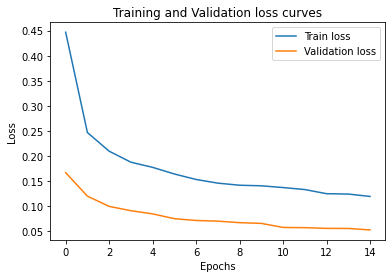

In [ ]:
plt.plot(epoch_counter, train_loss_per_epoch, label="Train loss")
plt.plot(epoch_counter, val_loss_per_epoch, label="Validation loss")
plt.title("Training and Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Evaluate the performance

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Test Loss: 0.048 | Test Acc: 98.34%


In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

Show the matrix

In [ ]:
images, labels, probs = get_predictions(model, test_loader, device)

# We take the predicted labels using the index of the highest predicted probability.
pred_labels = torch.argmax(probs, 1)

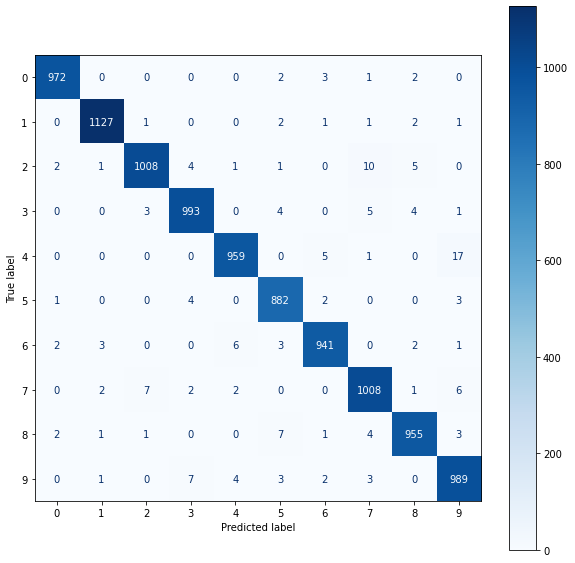

In [ ]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
model_path = "/content/gdrive/MyDrive/Clark/Deep_Learning/Models" 
torch.save(model.state_dict(), model_path)

RuntimeError: ignored

## Optional Task 3

Use the model above and the parameters for batch size, learning rate, and dropout to evaluate model performance. Repeat using the code above from Task 2: Show your work. Provide the outputs (loss curves, performance metrics), from the best and worst results in the cells below. 

**<font color='red'>5/5 points on optional 2</font>**



### Best result



Here is the model I used:


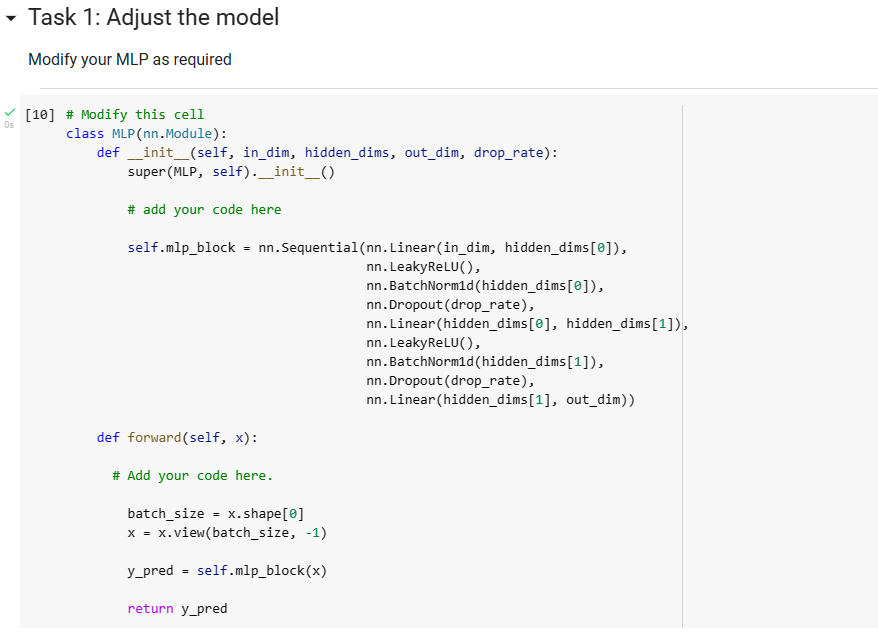

And the parameters:

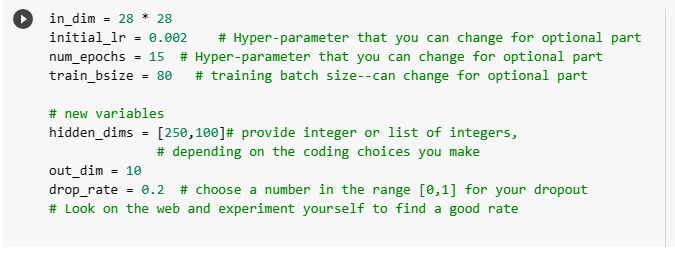

Loss Curve:

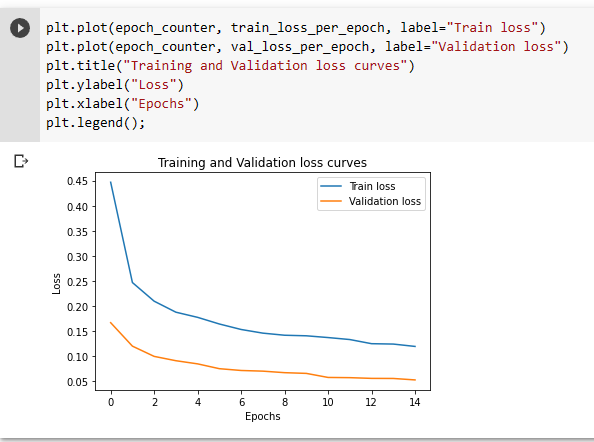

And confusion matrix:

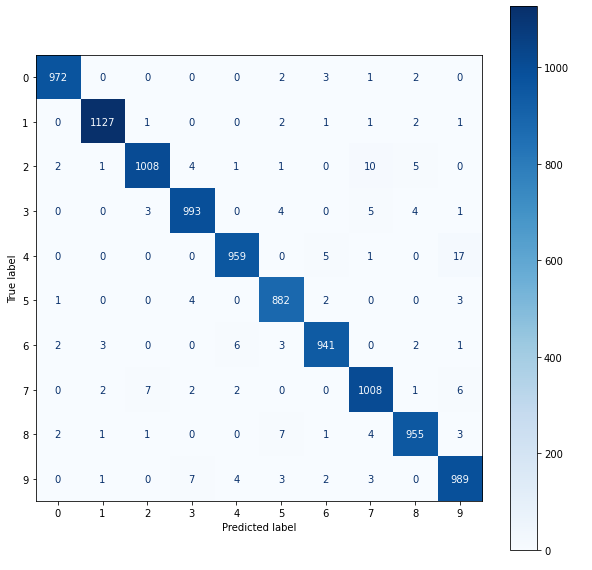

### Worst result

In [ ]:
#Parameters:

in_dim = 28 * 28
initial_lr = 0.001    # Hyper-parameter that you can change for optional part
num_epochs = 2    # Hyper-parameter that you can change for optional part
train_bsize = 2   # training batch size--can change for optional part

# new variables
hidden_dims = [10,10]# provide integer or list of integers, 
              # depending on the coding choices you make
out_dim = 10
drop_rate = 0.5  # choose a number in the range [0,1] for your dropout 
# Look on the web and experiment yourself to find a good rate


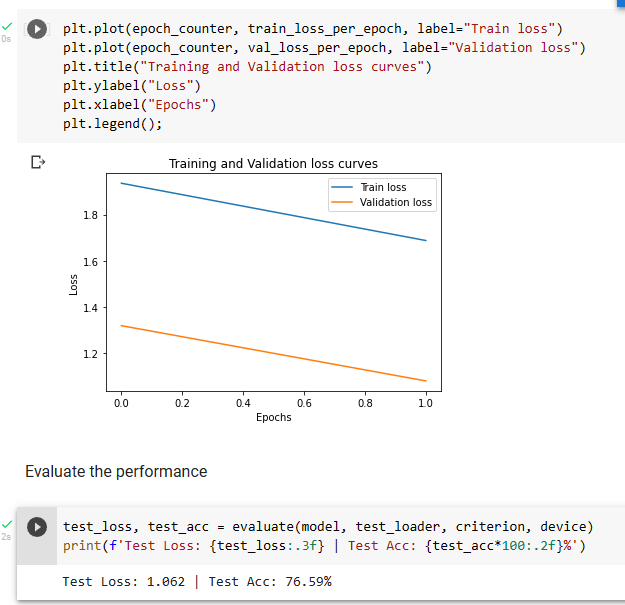

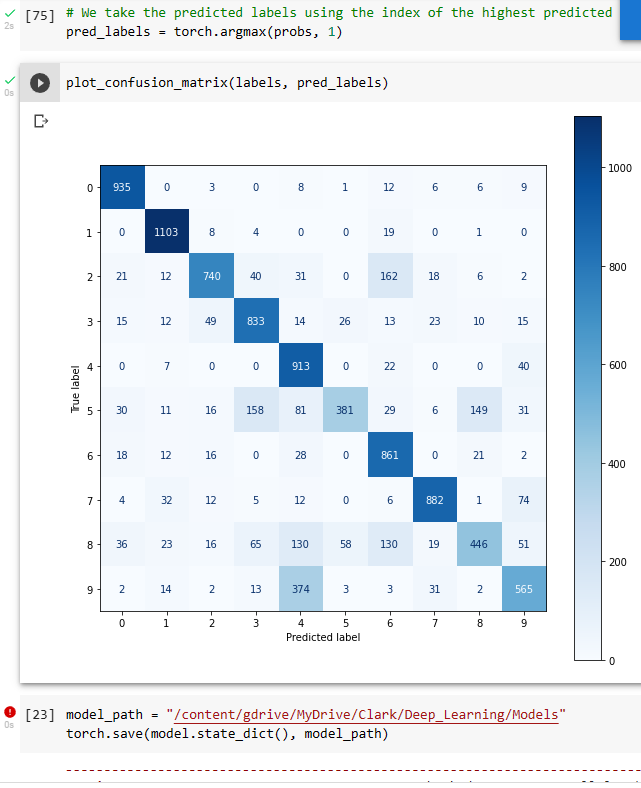